# Phân loại phân khúc đồng hồ bằng KNN và Random Forest

Trong notebook này, chúng ta sẽ:
1. Tải và khám phá dữ liệu
2. Tiền xử lý dữ liệu
3. Phân loại phân khúc đồng hồ sử dụng hai thuật toán:
   - K-Nearest Neighbors (KNN)
   - Random Forest (RF)
4. So sánh hiệu suất của hai thuật toán

In [207]:
# Import các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Cấu hình hiển thị
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Bỏ qua các cảnh báo
import warnings
warnings.filterwarnings('ignore')

## 1. Tải và khám phá dữ liệu

Chúng ta sẽ tải dữ liệu từ file CSV và khám phá cấu trúc của dữ liệu.

In [208]:
# Tải dữ liệu
# Kiểm tra cả train và test data để xem cấu trúc
train_df = pd.read_csv('../dataset/train_segmented.csv')
test_df = pd.read_csv('../dataset/test_segmented.csv')

print(f"Kích thước dữ liệu huấn luyện: {train_df.shape}")
print(f"Kích thước dữ liệu kiểm tra: {test_df.shape}")
print("\nDữ liệu huấn luyện:")
train_df.head()

Kích thước dữ liệu huấn luyện: (5665, 15)
Kích thước dữ liệu kiểm tra: (1476, 15)

Dữ liệu huấn luyện:


,case_material,band_material,case_back,bezel_material,brand,gender,movement,watch_style,case_thickness,crystal,hands,dial_markers,case_diameter,water_resistance,price_segment
0,Stainless Steel,Stainless Steel and 18kt Rose Gold,Transparent See Through,18kt Rose Gold,Audemars Piguet,WOMENS,Automatic,Luxury,8.800000,Scratch Resistant Sapphire,Rose Gold-tone,Index,34.0,50.0,3
1,Stainless Steel,Stainless Steel,Solid,Stainless Steel,Citizen,MENS,Quartz,Sport,9.500000,Crystal Glass,Silver-tone,Index,38.0,50.0,0
2,Stainless Steel,Silicone,Solid,Stainless Steel,Tissot,MENS,Quartz,Sport,11.800000,Scratch Resistant Sapphire,Rose Gold-tone,Index,45.0,100.0,0
3,Stainless Steel,Stainless Steel set with Crystals,Solid,Stainless Steel set with Crystals,Bulova,WOMENS,Quartz,Luxury,7.900000,Scratch Resistant Mineral,Silver-tone,Crystal,30.0,30.0,0
4,Stainless Steel,Stainless Steel,Solid,Stainless Steel,Mathey-Tissot,MENS,Quartz,Casual,11.196182,Scratch Resistant Mineral,Silver-tone,Arabic Numeral,40.0,50.0,0


In [209]:
# Kiểm tra thông tin về các cột trong dữ liệu
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5665 entries, 0 to 5664
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   case_material     5665 non-null   object 
 1   band_material     5665 non-null   object 
 2   case_back         5665 non-null   object 
 3   bezel_material    5665 non-null   object 
 4   brand             5665 non-null   object 
 5   gender            5665 non-null   object 
 6   movement          5665 non-null   object 
 7   watch_style       5665 non-null   object 
 8   case_thickness    5665 non-null   float64
 9   crystal           5665 non-null   object 
 10  hands             5665 non-null   object 
 11  dial_markers      5665 non-null   object 
 12  case_diameter     5665 non-null   float64
 13  water_resistance  5665 non-null   float64
 14  price_segment     5665 non-null   int64  
dtypes: float64(3), int64(1), object(11)
memory usage: 664.0+ KB


In [210]:
# Thống kê mô tả
train_df.describe(include='all')

,case_material,band_material,case_back,bezel_material,brand,gender,movement,watch_style,case_thickness,crystal,hands,dial_markers,case_diameter,water_resistance,price_segment
count,5665,5665,5665,5665,5665,5665,5665,5665,5665.000000,5665,5665,5665,5665.000000,5665.000000,5665.000000
unique,235,542,49,687,178,3,4,9,NaN,77,466,266,NaN,NaN,NaN
top,Stainless Steel,Stainless Steel,Solid,Stainless Steel,Rolex,MENS,Automatic,Luxury,NaN,Scratch Resistant Sapphire,Silver-tone,Index,NaN,NaN,NaN
freq,3753,1883,3520,2726,569,3577,3278,2518,NaN,4065,1478,2700,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.251044,NaN,NaN,NaN,38.580570,98.837664,0.957105
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.545895,NaN,NaN,NaN,5.968054,173.297575,1.077716
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.400000,NaN,NaN,NaN,12.000000,3.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,36.000000,30.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.196182,NaN,NaN,NaN,40.000000,50.000000,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.000000,NaN,NaN,NaN,42.000000,100.000000,1.000000


In [211]:
# Kiểm tra giá trị null
print("Số lượng giá trị null trong tập huấn luyện:")
print(train_df.isnull().sum())

print("\nSố lượng giá trị null trong tập kiểm tra:")
print(test_df.isnull().sum())

Số lượng giá trị null trong tập huấn luyện:
case_material       0
band_material       0
case_back           0
bezel_material      0
brand               0
gender              0
movement            0
watch_style         0
case_thickness      0
crystal             0
hands               0
dial_markers        0
case_diameter       0
water_resistance    0
price_segment       0
dtype: int64

Số lượng giá trị null trong tập kiểm tra:
case_material       0
band_material       0
case_back           0
bezel_material      0
brand               0
gender              0
movement            0
watch_style         0
case_thickness      0
crystal             0
hands               0
dial_markers        0
case_diameter       0
water_resistance    0
price_segment       0
dtype: int64


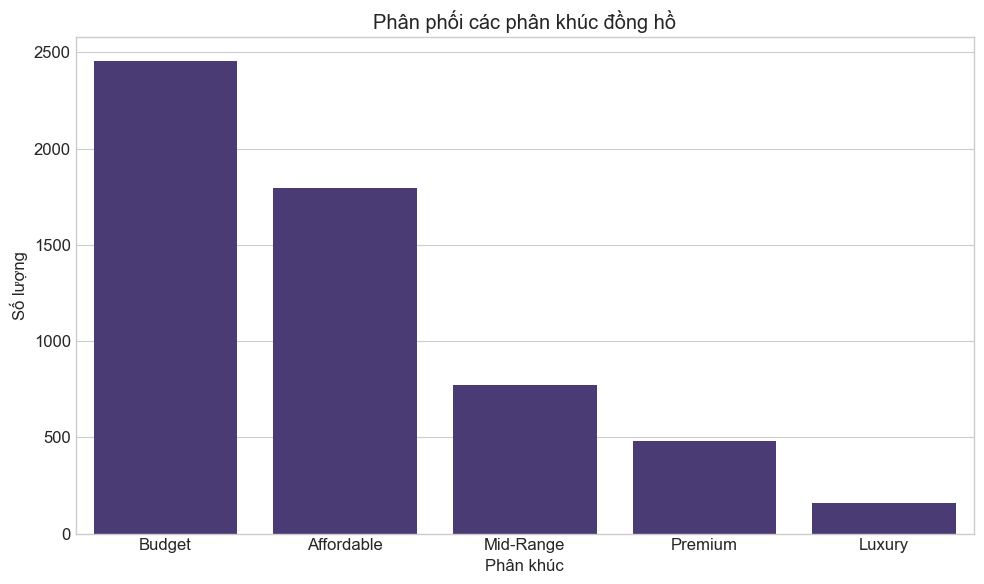

In [212]:
# Kiểm tra phân phối của biến mục tiêu (phân khúc đồng hồ)
labels = ['Budget', 'Affordable', 'Mid-Range', 'Premium', 'Luxury']
plt.figure(figsize=(10, 6))
sns.countplot(x='price_segment', data=train_df)
plt.title('Phân phối các phân khúc đồng hồ')
plt.xlabel('Phân khúc')
plt.ylabel('Số lượng')

# Thay nhãn trên trục X
plt.xticks(ticks=range(len(labels)), labels=labels)

plt.tight_layout()
plt.show()

## 2. Tiền xử lý dữ liệu

Trước khi áp dụng thuật toán, chúng ta cần tiền xử lý dữ liệu:
- Xử lý giá trị thiếu (nếu có)
- Mã hóa các biến phân loại
- Chuẩn hóa/Scaling các đặc trưng số

In [213]:
# Xử lý dữ liệu bị thiếu (nếu có)
# Điền giá trị thiếu cho các cột số bằng giá trị trung bình
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    if train_df[col].isnull().sum() > 0:
        train_df[col].fillna(train_df[col].mean(), inplace=True)
        test_df[col].fillna(train_df[col].mean(), inplace=True)

# Điền giá trị thiếu cho các cột phân loại bằng giá trị phổ biến nhất
cat_cols = train_df.select_dtypes(include=['object']).columns
for col in cat_cols:
    if train_df[col].isnull().sum() > 0:
        train_df[col].fillna(train_df[col].mode()[0], inplace=True)
        test_df[col].fillna(train_df[col].mode()[0], inplace=True)

# Kiểm tra lại sau khi xử lý
print("Số lượng giá trị null sau khi xử lý trong tập huấn luyện:")
print(train_df.isnull().sum().sum())

print("\nSố lượng giá trị null sau khi xử lý trong tập kiểm tra:")
print(test_df.isnull().sum().sum())

Số lượng giá trị null sau khi xử lý trong tập huấn luyện:
0

Số lượng giá trị null sau khi xử lý trong tập kiểm tra:
0


In [214]:
# Chuẩn bị dữ liệu cho mô hình
# Tách đặc trưng và biến mục tiêu
X_train = train_df.drop('price_segment', axis=1)
y_train = train_df['price_segment']
X_test = test_df.drop('price_segment', axis=1)
y_test = test_df['price_segment']  # Lưu trữ nhãn thực tế từ tập kiểm tra

display(X_train.head())

print(f"Kích thước X_train: {X_train.shape}")
print(f"Kích thước X_test: {X_test.shape}")

# Kiểm tra các cột phân loại cần mã hóa
cat_cols = X_train.select_dtypes(include=['object']).columns
print(f"Các cột phân loại cần mã hóa: {list(cat_cols)}")

import json

# Đọc encoding parameters từ file JSON
with open("../dataset/encoding_params.json", "r") as f:
    encoding_params = json.load(f)

target_encoding_map = encoding_params.get("target_encoding", {})
onehot_encoding_map = encoding_params.get("onehot_encoding", {})
# print("Target encoding parameters:", target_encoding_map)

# Áp dụng target encoding
for col, mapping in target_encoding_map.items():
    X_train[col] = X_train[col].map(mapping).fillna(0)
    X_test[col] = X_test[col].map(mapping).fillna(0)

# Áp dụng one-hot encoding
for col, categories in onehot_encoding_map.items():
    for category in categories:
        X_train[f"{col}_{category}"] = (X_train[col] == category).astype(int)
        X_test[f"{col}_{category}"] = (X_test[col] == category).astype(int)
    X_train.drop(columns=[col], inplace=True)
    X_test.drop(columns=[col], inplace=True)


print("Đã áp dụng target encoding và one-hot encoding cho các cột phân loại.")
X_train.head()

,case_material,band_material,case_back,bezel_material,brand,gender,movement,watch_style,case_thickness,crystal,hands,dial_markers,case_diameter,water_resistance
0,Stainless Steel,Stainless Steel and 18kt Rose Gold,Transparent See Through,18kt Rose Gold,Audemars Piguet,WOMENS,Automatic,Luxury,8.800000,Scratch Resistant Sapphire,Rose Gold-tone,Index,34.0,50.0
1,Stainless Steel,Stainless Steel,Solid,Stainless Steel,Citizen,MENS,Quartz,Sport,9.500000,Crystal Glass,Silver-tone,Index,38.0,50.0
2,Stainless Steel,Silicone,Solid,Stainless Steel,Tissot,MENS,Quartz,Sport,11.800000,Scratch Resistant Sapphire,Rose Gold-tone,Index,45.0,100.0
3,Stainless Steel,Stainless Steel set with Crystals,Solid,Stainless Steel set with Crystals,Bulova,WOMENS,Quartz,Luxury,7.900000,Scratch Resistant Mineral,Silver-tone,Crystal,30.0,30.0
4,Stainless Steel,Stainless Steel,Solid,Stainless Steel,Mathey-Tissot,MENS,Quartz,Casual,11.196182,Scratch Resistant Mineral,Silver-tone,Arabic Numeral,40.0,50.0


Kích thước X_train: (5665, 14)
Kích thước X_test: (1476, 14)
Các cột phân loại cần mã hóa: ['case_material', 'band_material', 'case_back', 'bezel_material', 'brand', 'gender', 'movement', 'watch_style', 'crystal', 'hands', 'dial_markers']
Đã áp dụng target encoding và one-hot encoding cho các cột phân loại.


,case_material,band_material,case_back,bezel_material,brand,watch_style,case_thickness,crystal,hands,dial_markers,case_diameter,water_resistance,gender_WOMENS,gender_MENS,gender_UNISEX,movement_Automatic,movement_Quartz,movement_Hand Wind,movement_Eco-Drive
0,4588.540389,12710.320734,36610.858311,45703.353506,175516.226515,33312.181424,8.800000,22835.274851,22055.677704,14007.021143,34.0,50.0,1,0,0,1,0,0,0
1,4588.540389,4160.754392,9612.898846,3992.157672,582.830884,7272.004906,9.500000,12424.161678,17488.354007,14007.021143,38.0,50.0,0,1,0,0,1,0,0
2,4588.540389,13929.806903,9612.898846,3992.157672,1112.595181,7272.004906,11.800000,22835.274851,22055.677704,14007.021143,45.0,100.0,0,1,0,0,1,0,0
3,4588.540389,4761.007319,9612.898846,2084.065157,1901.819844,33312.181424,7.900000,830.277630,17488.354007,1596.193539,30.0,30.0,1,0,0,0,1,0,0
4,4588.540389,4160.754392,9612.898846,3992.157672,647.170349,1212.959741,11.196182,830.277630,17488.354007,25695.879160,40.0,50.0,0,1,0,0,1,0,0


In [215]:
# Mã hóa biến mục tiêu (nếu chưa là số)
if y_train.dtype == 'object':
    le_target = LabelEncoder()
    y_train_encoded = le_target.fit_transform(y_train)
    y_test_encoded = le_target.transform(y_test)
    
    # Hiển thị mapping của các phân khúc
    segment_mapping = dict(zip(le_target.classes_, range(len(le_target.classes_))))
    print("Mapping của các phân khúc:")
    for segment, code in segment_mapping.items():
        print(f"{segment}: {code}")
else:
    # Nếu đã là số, sử dụng trực tiếp
    y_train_encoded = y_train.values
    y_test_encoded = y_test.values
    print("Biến mục tiêu đã là số, không cần mã hóa thêm.")
    
    # Tạo nhãn lớp cho việc hiển thị
    unique_segments = sorted(y_train.unique())
    target_names = [str(segment) for segment in unique_segments]

Biến mục tiêu đã là số, không cần mã hóa thêm.


## 3. Xây dựng và đánh giá mô hình

### 3.1. K-Nearest Neighbors (KNN)

Thuật toán KNN phân loại một điểm dữ liệu dựa trên phần lớn nhãn của k điểm dữ liệu gần nhất với nó. Chúng ta sẽ tìm giá trị k tối ưu bằng cross-validation.

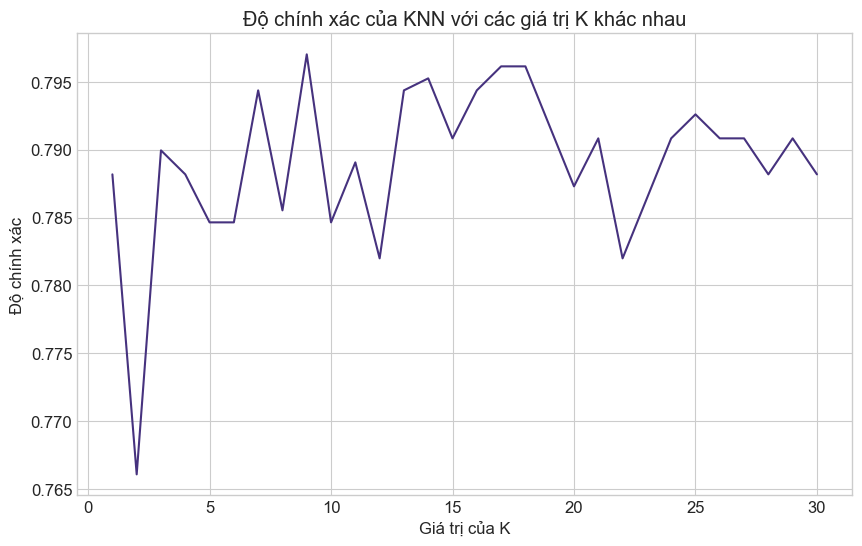

Giá trị k tốt nhất: 9 với độ chính xác: 0.7970


In [216]:
# Tìm giá trị k tốt nhất
k_range = list(range(1, 31))
k_scores = []

# Chia dữ liệu huấn luyện thành tập huấn luyện và tập validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train_encoded, test_size=0.2, random_state=42
)

# Tính điểm cho từng giá trị k
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_split, y_train_split)
    scores = knn.score(X_val_split, y_val_split)
    k_scores.append(scores)

# Vẽ đồ thị điểm số
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores)
plt.xlabel('Giá trị của K')
plt.ylabel('Độ chính xác')
plt.title('Độ chính xác của KNN với các giá trị K khác nhau')
plt.grid(True)
plt.show()

# Tìm k tốt nhất
best_k = k_range[k_scores.index(max(k_scores))]
print(f"Giá trị k tốt nhất: {best_k} với độ chính xác: {max(k_scores):.4f}")

Độ chính xác trên tập huấn luyện của KNN: 0.8370697263901148
Điểm cross-validation của KNN: 0.7982 ± 0.0133


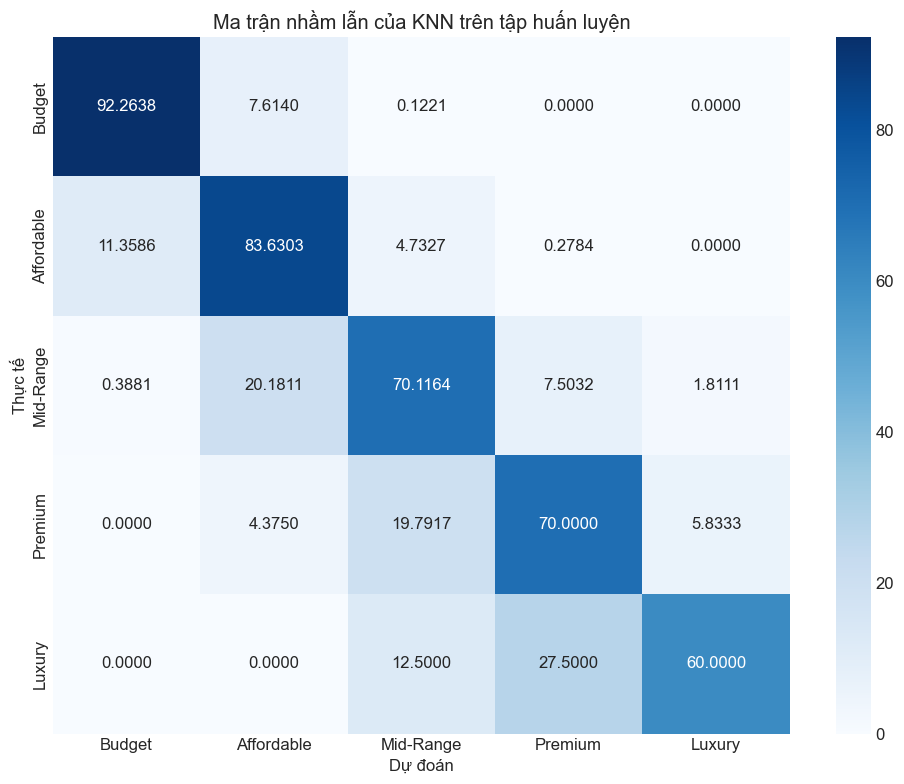


Báo cáo phân loại chi tiết của KNN:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2456
           1       0.80      0.84      0.82      1796
           2       0.73      0.70      0.71       773
           3       0.76      0.70      0.73       480
           4       0.70      0.60      0.64       160

    accuracy                           0.84      5665
   macro avg       0.78      0.75      0.77      5665
weighted avg       0.84      0.84      0.84      5665



In [217]:
# Huấn luyện mô hình KNN với k tốt nhất
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train_encoded)

# Đánh giá trên tập huấn luyện
y_train_pred_knn = knn_best.predict(X_train)
print("Độ chính xác trên tập huấn luyện của KNN:", accuracy_score(y_train_encoded, y_train_pred_knn))

# Đánh giá bằng cross-validation
cv_scores_knn = cross_val_score(knn_best, X_train, y_train_encoded, cv=5)
print(f"Điểm cross-validation của KNN: {cv_scores_knn.mean():.4f} ± {cv_scores_knn.std():.4f}")

# Ma trận nhầm lẫn trên tập huấn luyện
plt.figure(figsize=(10, 8))
cm_knn = confusion_matrix(y_train_encoded, y_train_pred_knn)
cm_knn_percent = cm_knn.astype('float') / cm_knn.sum(axis=1)[:, np.newaxis] * 100

sns.heatmap(cm_knn_percent, annot=True, fmt='.4f', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Ma trận nhầm lẫn của KNN trên tập huấn luyện')
plt.tight_layout()
plt.show()

# Báo cáo phân loại chi tiết
print("\nBáo cáo phân loại chi tiết của KNN:")
if y_train.dtype == 'object':
    print(classification_report(y_train_encoded, y_train_pred_knn, target_names=le_target.classes_))
else:
    print(classification_report(y_train_encoded, y_train_pred_knn, 
                              target_names=[str(i) for i in sorted(y_train.unique())]))

### 3.2. Random Forest (RF)

Random Forest là một thuật toán ensemble sử dụng nhiều cây quyết định để đưa ra dự đoán. Chúng ta sẽ tìm kiếm các tham số tốt nhất cho Random Forest.

In [218]:
# # Huấn luyện mô hình Random Forest với các tham số mặc định
# rf = RandomForestClassifier(random_state=42)
# rf.fit(X_train, y_train_encoded)

# # Đánh giá trên tập huấn luyện
# y_train_pred_rf = rf.predict(X_train)
# print("Độ chính xác trên tập huấn luyện của Random Forest:", 
#       accuracy_score(y_train_encoded, y_train_pred_rf))

# # Đánh giá bằng cross-validation
# cv_scores_rf = cross_val_score(rf, X_train, y_train_encoded, cv=5)
# print(f"Điểm cross-validation của Random Forest: {cv_scores_rf.mean():.4f} ± {cv_scores_rf.std():.4f}")

# # Ma trận nhầm lẫn trên tập huấn luyện
# plt.figure(figsize=(10, 8))
# cm_rf = confusion_matrix(y_train_encoded, y_train_pred_rf)
# cm_rf_percent = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis] * 100
# labels = ['Budget', 'Affordable', 'Mid-Range', 'Premium', 'Luxury']

# sns.heatmap(cm_rf_percent, annot=True, fmt='.2f', cmap='Blues', 
#             xticklabels=labels, yticklabels=labels)
# plt.xlabel('Dự đoán')
# plt.ylabel('Thực tế')
# plt.title('Ma trận nhầm lẫn của Random Forest trên tập huấn luyện')
# plt.tight_layout()
# plt.show()

# # Báo cáo phân loại chi tiết
# print("\nBáo cáo phân loại chi tiết của Random Forest:")
# if y_train.dtype == 'object':
#     print(classification_report(
#         y_train_encoded,
#         y_train_pred_rf,
#         target_names=le_target.classes_,
#         digits=4               # <-- làm tròn 4 chữ số thập phân
#     ))
# else:
#     print(classification_report(
#         y_train_encoded,
#         y_train_pred_rf,
#         target_names=[str(i) for i in sorted(y_train.unique())],
#         digits=4               # <-- làm tròn 4 chữ số thập phân
#     ))

In [219]:
# # Tìm tham số tốt nhất cho Random Forest bằng GridSearchCV
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Thực hiện tìm kiếm lưới
# grid_search = GridSearchCV(RandomForestClassifier(random_state=42), 
#                          param_grid=param_grid, 
#                          cv=5, 
#                          n_jobs=-1,
#                          verbose=1)

# grid_search.fit(X_train, y_train_encoded)

# # In ra tham số tốt nhất
# print("Tham số tốt nhất cho Random Forest:")
# print(grid_search.best_params_)
# print(f"Điểm số tốt nhất: {grid_search.best_score_:.4f}")

In [220]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# Khai báo không gian tham số 
param_dist = {
    'n_estimators'     : randint(100, 301),
    'max_depth'        : randint(5, 21),
    'min_samples_split': randint(5, 16),
    'min_samples_leaf' : randint(2, 11),
    'max_features'     : ['sqrt', 'log2'],
    'bootstrap'        : [True],
    'max_leaf_nodes'   : randint(50, 201)
}

# Tạo đối tượng RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,            # thử ngẫu nhiên 20 tổ hợp
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Huấn luyện với tập train
random_search.fit(X_train, y_train_encoded)

# In ra kết quả
print("Tham số tốt nhất với Random Search:")
print(random_search.best_params_)
print(f"Điểm F1 (hoặc Accuracy) tốt nhất: {random_search.best_score_:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tham số tốt nhất với Random Search:
{'bootstrap': True, 'max_depth': 14, 'max_features': 'sqrt', 'max_leaf_nodes': 179, 'min_samples_leaf': 5, 'min_samples_split': 11, 'n_estimators': 271}
Điểm F1 (hoặc Accuracy) tốt nhất: 0.8669


Độ chính xác trên tập huấn luyện của Random Forest tốt nhất: 0.9221535745807591
Điểm cross-validation của Random Forest tốt nhất: 0.8669 ± 0.0042


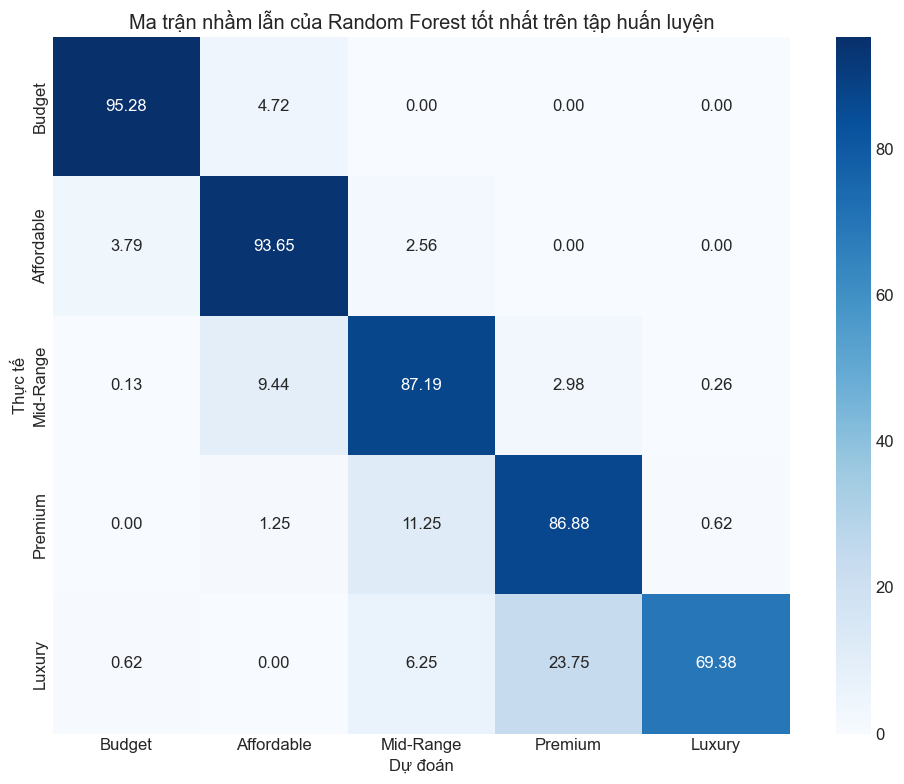


Báo cáo phân loại chi tiết của Random Forest tốt nhất:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2456
           1       0.90      0.94      0.92      1796
           2       0.86      0.87      0.87       773
           3       0.87      0.87      0.87       480
           4       0.96      0.69      0.80       160

    accuracy                           0.92      5665
   macro avg       0.91      0.86      0.88      5665
weighted avg       0.92      0.92      0.92      5665



In [221]:
# Huấn luyện Random Forest với tham số tốt nhất
# rf_best = grid_search.best_estimator_

rf_best = random_search.best_estimator_

# Đánh giá trên tập huấn luyện
y_train_pred_rf_best = rf_best.predict(X_train)
print("Độ chính xác trên tập huấn luyện của Random Forest tốt nhất:", 
      accuracy_score(y_train_encoded, y_train_pred_rf_best))

# Đánh giá bằng cross-validation
cv_scores_rf_best = cross_val_score(rf_best, X_train, y_train_encoded, cv=5)
print(f"Điểm cross-validation của Random Forest tốt nhất: {cv_scores_rf_best.mean():.4f} ± {cv_scores_rf_best.std():.4f}")

# Ma trận nhầm lẫn trên tập huấn luyện
plt.figure(figsize=(10, 8))
cm_rf_best = confusion_matrix(y_train_encoded, y_train_pred_rf_best)
cm_rf_best_percent = cm_rf_best.astype('float') / cm_rf_best.sum(axis=1)[:, np.newaxis] * 100
labels = ['Budget', 'Affordable', 'Mid-Range', 'Premium', 'Luxury']

sns.heatmap(cm_rf_best_percent, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Ma trận nhầm lẫn của Random Forest tốt nhất trên tập huấn luyện')
plt.tight_layout()
plt.show()

# Báo cáo phân loại chi tiết
print("\nBáo cáo phân loại chi tiết của Random Forest tốt nhất:")
if y_train.dtype == 'object':
    print(classification_report(y_train_encoded, y_train_pred_rf_best, target_names=le_target.classes_))
else:
    print(classification_report(y_train_encoded, y_train_pred_rf_best, 
                              target_names=[str(i) for i in sorted(y_train.unique())]))

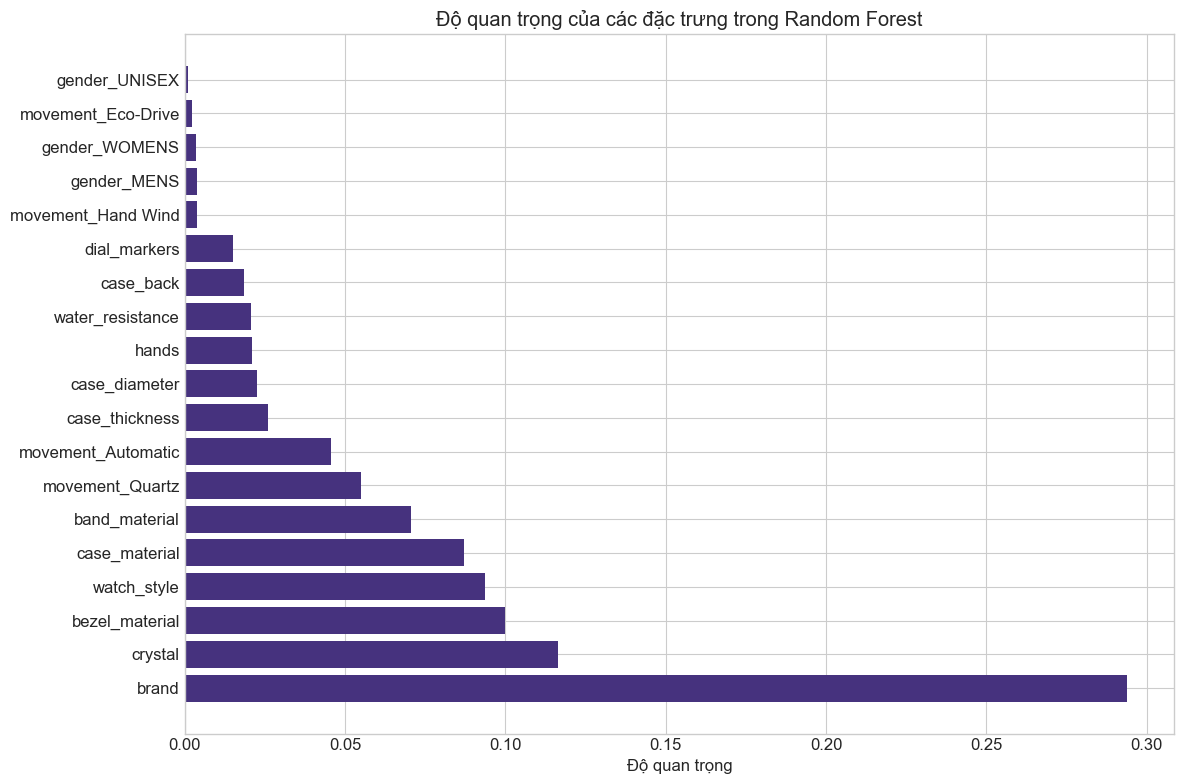

In [222]:
# Phân tích tầm quan trọng của đặc trưng trong Random Forest
feature_importances = rf_best.feature_importances_
feature_names = X_train.columns

# Sắp xếp các đặc trưng theo độ quan trọng
sorted_idx = feature_importances.argsort()[::-1]

# Vẽ biểu đồ cột
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Độ quan trọng')
plt.title('Độ quan trọng của các đặc trưng trong Random Forest')
plt.tight_layout()
plt.show()

# 4. So sánh hiệu suất của các mô hình

So sánh hiệu suất của hai mô hình: KNN và Random Forest

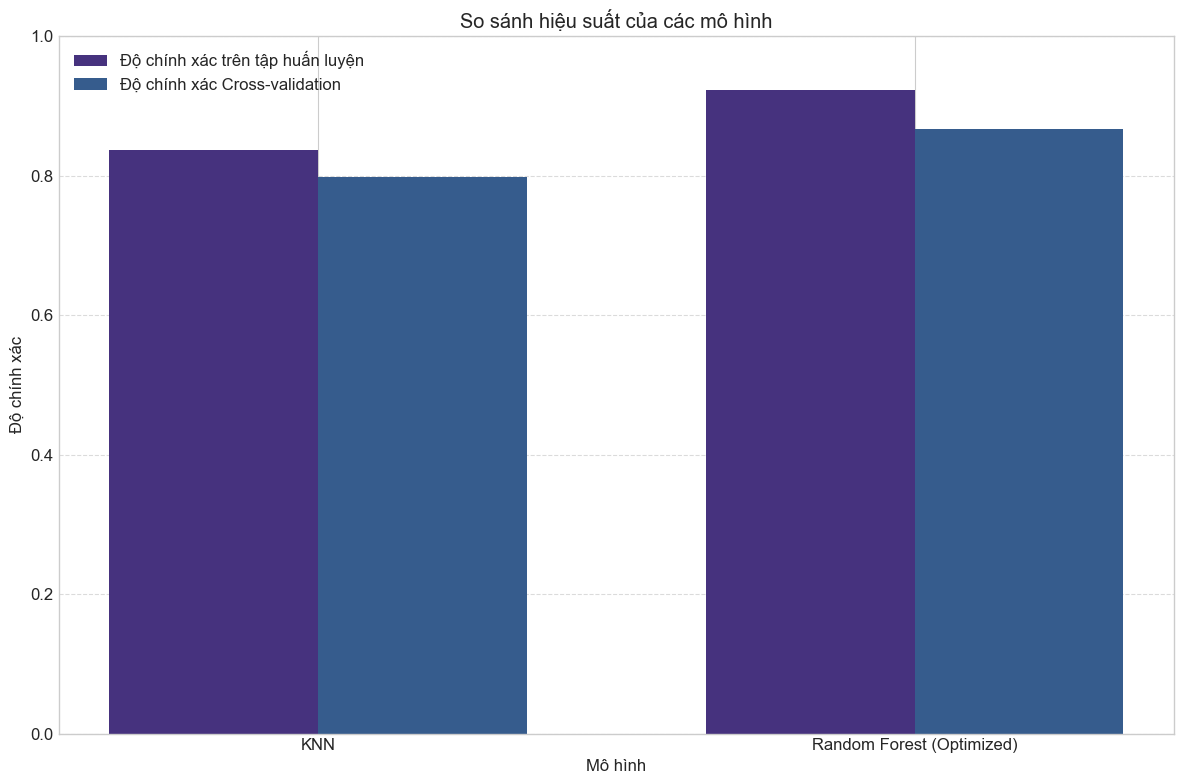

In [223]:
# So sánh hiệu suất của các mô hình
models = ['KNN',
        #    'Random Forest (Default)',
             'Random Forest (Optimized)']
accuracy_train = [accuracy_score(y_train_encoded, y_train_pred_knn),
                #   accuracy_score(y_train_encoded, y_train_pred_rf),
                  accuracy_score(y_train_encoded, y_train_pred_rf_best)]
cv_scores = [cv_scores_knn.mean(),
            #   cv_scores_rf.mean(),
            cv_scores_rf_best.mean()]

# Tạo biểu đồ so sánh
plt.figure(figsize=(12, 8))
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, accuracy_train, width, label='Độ chính xác trên tập huấn luyện')
plt.bar(x + width/2, cv_scores, width, label='Độ chính xác Cross-validation')

plt.xlabel('Mô hình')
plt.ylabel('Độ chính xác')
plt.title('So sánh hiệu suất của các mô hình')
plt.xticks(x, models)
plt.ylim([0, 1])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 4.1 So sánh chi tiết các metrics

So sánh chi tiết các metrics giữa hai mô hình (KNN và Random Forest) để có cái nhìn toàn diện hơn về hiệu suất.

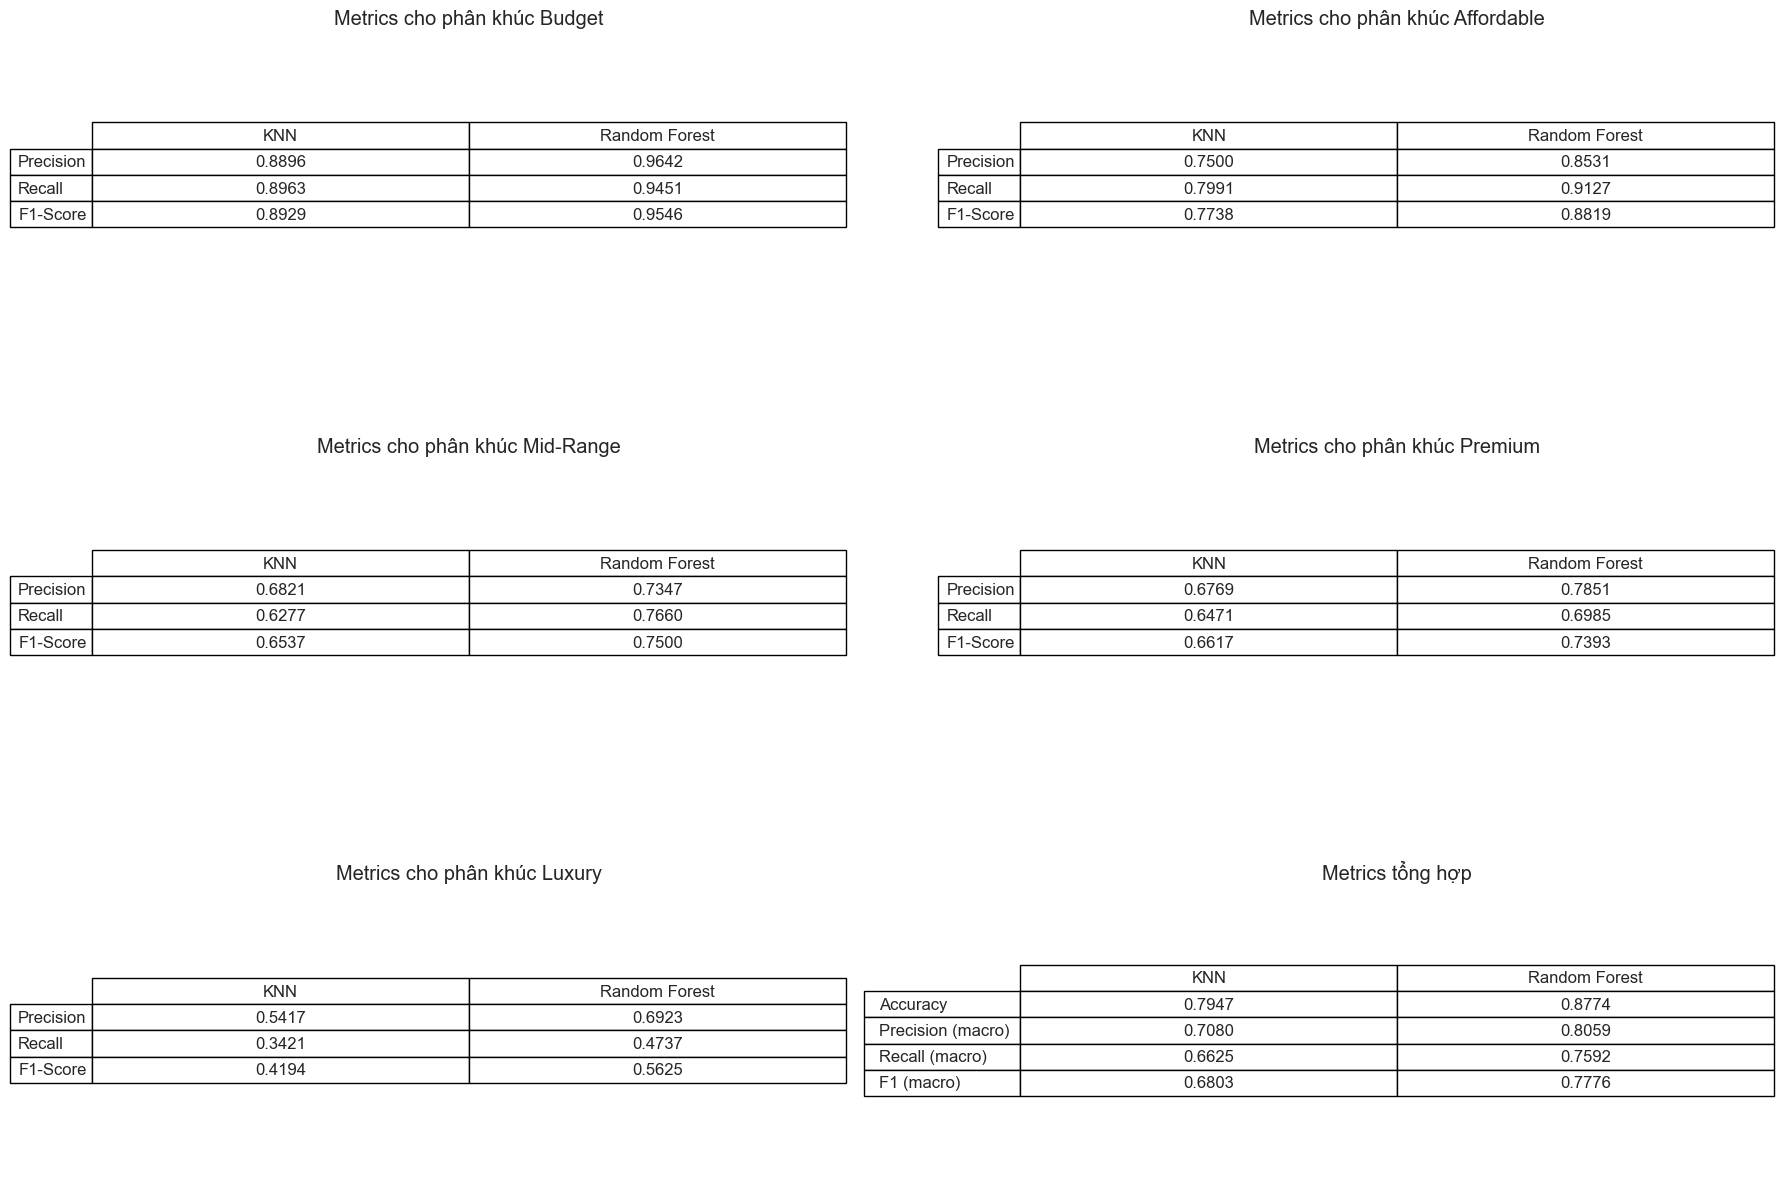

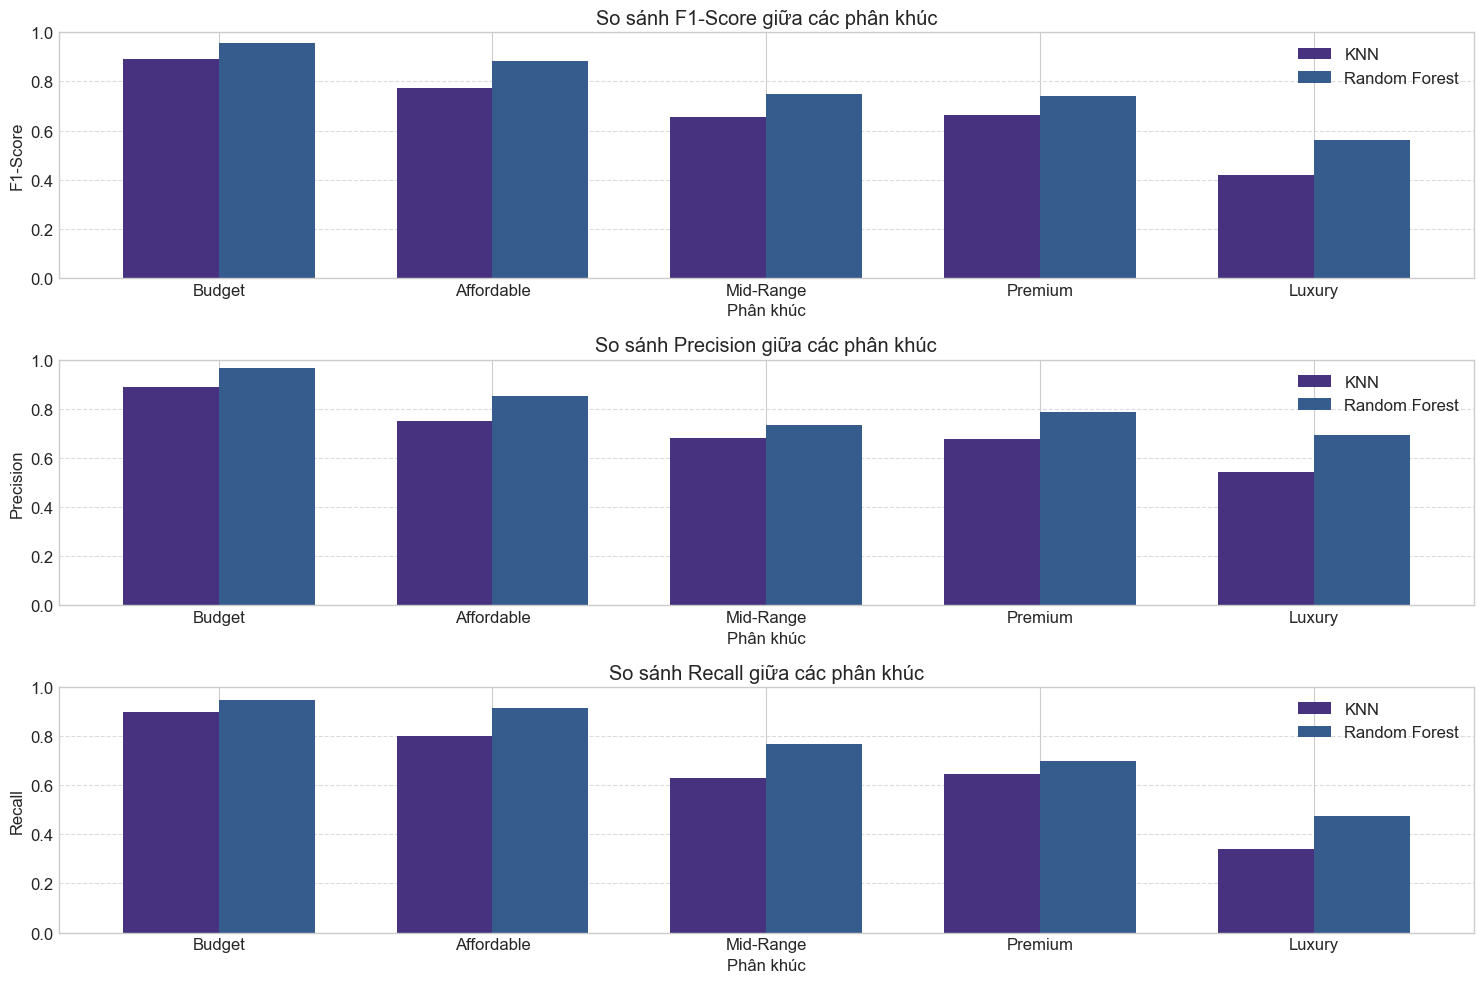

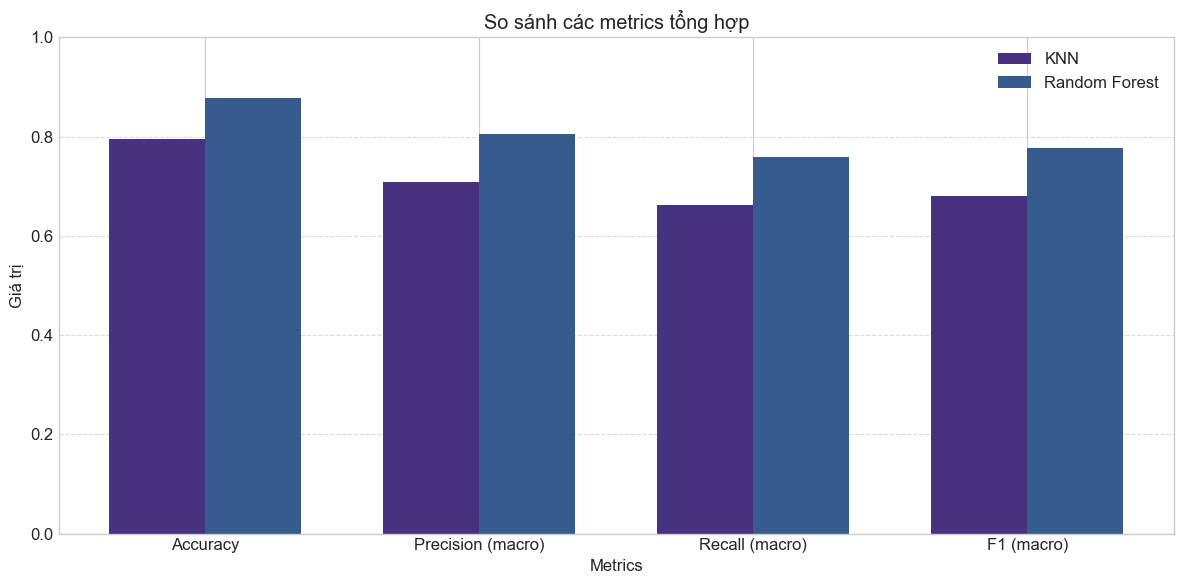

So sánh chi tiết tất cả metrics:
              Metric    KNN  Random Forest
            Accuracy 0.7947         0.8774
   Precision (macro) 0.7080         0.8059
      Recall (macro) 0.6625         0.7592
          F1 (macro) 0.6803         0.7776
Precision (weighted) 0.7913         0.8770
   Recall (weighted) 0.7947         0.8774
       F1 (weighted) 0.7920         0.8760

Đã lưu metrics so sánh vào file '../dataset/model_metrics_comparison.csv'

So sánh chi tiết metrics cho từng phân khúc:

Phân khúc Budget:
   Metric    KNN  Random Forest
Precision 0.8896         0.9642
   Recall 0.8963         0.9451
 F1-Score 0.8929         0.9546

Phân khúc Affordable:
   Metric    KNN  Random Forest
Precision 0.7500         0.8531
   Recall 0.7991         0.9127
 F1-Score 0.7738         0.8819

Phân khúc Mid-Range:
   Metric    KNN  Random Forest
Precision 0.6821         0.7347
   Recall 0.6277         0.7660
 F1-Score 0.6537         0.7500

Phân khúc Premium:
   Metric    KNN  Random Forest
Pr

In [224]:
# Tính toán metrics chi tiết cho từng mô hình
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Dự đoán trên tập test
y_test_pred_knn = knn_best.predict(X_test)
y_test_pred_rf_best = rf_best.predict(X_test)

# Tính toán metrics trên từng lớp
metrics_per_class = {}

# Các nhãn phân khúc
labels = ['Budget', 'Affordable', 'Mid-Range', 'Premium', 'Luxury']

# Tính toán precision, recall, f1-score cho từng lớp
for i, label in enumerate(labels):
    metrics_per_class[label] = {
        'KNN': {
            'precision': precision_score(y_test_encoded, y_test_pred_knn, labels=[i], average=None)[0],
            'recall': recall_score(y_test_encoded, y_test_pred_knn, labels=[i], average=None)[0],
            'f1': f1_score(y_test_encoded, y_test_pred_knn, labels=[i], average=None)[0]
        },
        'RF': {
            'precision': precision_score(y_test_encoded, y_test_pred_rf_best, labels=[i], average=None)[0],
            'recall': recall_score(y_test_encoded, y_test_pred_rf_best, labels=[i], average=None)[0],
            'f1': f1_score(y_test_encoded, y_test_pred_rf_best, labels=[i], average=None)[0]
        }
    }

# Tính toán metrics tổng hợp
overall_metrics = {
    'KNN': {
        'accuracy': accuracy_score(y_test_encoded, y_test_pred_knn),
        'precision_macro': precision_score(y_test_encoded, y_test_pred_knn, average='macro'),
        'recall_macro': recall_score(y_test_encoded, y_test_pred_knn, average='macro'),
        'f1_macro': f1_score(y_test_encoded, y_test_pred_knn, average='macro'),
        'precision_weighted': precision_score(y_test_encoded, y_test_pred_knn, average='weighted'),
        'recall_weighted': recall_score(y_test_encoded, y_test_pred_knn, average='weighted'),
        'f1_weighted': f1_score(y_test_encoded, y_test_pred_knn, average='weighted')
    },
    'RF': {
        'accuracy': accuracy_score(y_test_encoded, y_test_pred_rf_best),
        'precision_macro': precision_score(y_test_encoded, y_test_pred_rf_best, average='macro'),
        'recall_macro': recall_score(y_test_encoded, y_test_pred_rf_best, average='macro'),
        'f1_macro': f1_score(y_test_encoded, y_test_pred_rf_best, average='macro'),
        'precision_weighted': precision_score(y_test_encoded, y_test_pred_rf_best, average='weighted'),
        'recall_weighted': recall_score(y_test_encoded, y_test_pred_rf_best, average='weighted'),
        'f1_weighted': f1_score(y_test_encoded, y_test_pred_rf_best, average='weighted')
    }
}

# Hiển thị kết quả cho từng phân khúc
plt.figure(figsize=(18, 12))

# Tạo bảng cho từng phân khúc
for i, label in enumerate(labels):
    plt.subplot(3, 2, i+1)
    
    # Dữ liệu cho KNN và RF
    metrics_data = [
        [metrics_per_class[label]['KNN']['precision'], metrics_per_class[label]['RF']['precision']],
        [metrics_per_class[label]['KNN']['recall'], metrics_per_class[label]['RF']['recall']],
        [metrics_per_class[label]['KNN']['f1'], metrics_per_class[label]['RF']['f1']]
    ]
    
    # Tạo bảng
    table = plt.table(
        cellText=[[f"{val:.4f}" for val in row] for row in metrics_data],
        rowLabels=['Precision', 'Recall', 'F1-Score'],
        colLabels=['KNN', 'Random Forest'],
        loc='center',
        cellLoc='center'
    )
    
    # Định dạng bảng
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)
    
    # Tắt trục
    plt.axis('off')
    plt.title(f'Metrics cho phân khúc {label}')

# Hiển thị metrics tổng hợp
plt.subplot(3, 2, 6)
metrics_overall = [
    [overall_metrics['KNN']['accuracy'], overall_metrics['RF']['accuracy']],
    [overall_metrics['KNN']['precision_macro'], overall_metrics['RF']['precision_macro']],
    [overall_metrics['KNN']['recall_macro'], overall_metrics['RF']['recall_macro']],
    [overall_metrics['KNN']['f1_macro'], overall_metrics['RF']['f1_macro']]
]

overall_table = plt.table(
    cellText=[[f"{val:.4f}" for val in row] for row in metrics_overall],
    rowLabels=['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1 (macro)'],
    colLabels=['KNN', 'Random Forest'],
    loc='center',
    cellLoc='center'
)

overall_table.auto_set_font_size(False)
overall_table.set_fontsize(12)
overall_table.scale(1, 1.5)
plt.axis('off')
plt.title('Metrics tổng hợp')

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()

# ----- Vẽ biểu đồ so sánh các metrics -----

# 1. Vẽ biểu đồ so sánh F1-score giữa các phân khúc
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
x = np.arange(len(labels))
width = 0.35

f1_knn = [metrics_per_class[label]['KNN']['f1'] for label in labels]
f1_rf = [metrics_per_class[label]['RF']['f1'] for label in labels]

plt.bar(x - width/2, f1_knn, width, label='KNN')
plt.bar(x + width/2, f1_rf, width, label='Random Forest')

plt.xlabel('Phân khúc')
plt.ylabel('F1-Score')
plt.title('So sánh F1-Score giữa các phân khúc')
plt.xticks(x, labels)
plt.ylim([0, 1])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 2. Vẽ biểu đồ so sánh Precision giữa các phân khúc
plt.subplot(3, 1, 2)
precision_knn = [metrics_per_class[label]['KNN']['precision'] for label in labels]
precision_rf = [metrics_per_class[label]['RF']['precision'] for label in labels]

plt.bar(x - width/2, precision_knn, width, label='KNN')
plt.bar(x + width/2, precision_rf, width, label='Random Forest')

plt.xlabel('Phân khúc')
plt.ylabel('Precision')
plt.title('So sánh Precision giữa các phân khúc')
plt.xticks(x, labels)
plt.ylim([0, 1])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 3. Vẽ biểu đồ so sánh Recall giữa các phân khúc
plt.subplot(3, 1, 3)
recall_knn = [metrics_per_class[label]['KNN']['recall'] for label in labels]
recall_rf = [metrics_per_class[label]['RF']['recall'] for label in labels]

plt.bar(x - width/2, recall_knn, width, label='KNN')
plt.bar(x + width/2, recall_rf, width, label='Random Forest')

plt.xlabel('Phân khúc')
plt.ylabel('Recall')
plt.title('So sánh Recall giữa các phân khúc')
plt.xticks(x, labels)
plt.ylim([0, 1])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 4. Vẽ biểu đồ tóm tắt so sánh các metrics tổng hợp
plt.figure(figsize=(12, 6))
metrics_names = ['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1 (macro)']
x = np.arange(len(metrics_names))
width = 0.35

metrics_knn = [
    overall_metrics['KNN']['accuracy'],
    overall_metrics['KNN']['precision_macro'],
    overall_metrics['KNN']['recall_macro'],
    overall_metrics['KNN']['f1_macro']
]

metrics_rf = [
    overall_metrics['RF']['accuracy'],
    overall_metrics['RF']['precision_macro'],
    overall_metrics['RF']['recall_macro'],
    overall_metrics['RF']['f1_macro']
]

plt.bar(x - width/2, metrics_knn, width, label='KNN')
plt.bar(x + width/2, metrics_rf, width, label='Random Forest')

plt.xlabel('Metrics')
plt.ylabel('Giá trị')
plt.title('So sánh các metrics tổng hợp')
plt.xticks(x, metrics_names)
plt.ylim([0, 1])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# In bảng so sánh tất cả metrics
print("So sánh chi tiết tất cả metrics:")
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1 (macro)', 
               'Precision (weighted)', 'Recall (weighted)', 'F1 (weighted)'],
    'KNN': [
        overall_metrics['KNN']['accuracy'],
        overall_metrics['KNN']['precision_macro'],
        overall_metrics['KNN']['recall_macro'],
        overall_metrics['KNN']['f1_macro'],
        overall_metrics['KNN']['precision_weighted'],
        overall_metrics['KNN']['recall_weighted'],
        overall_metrics['KNN']['f1_weighted']
    ],
    'Random Forest': [
        overall_metrics['RF']['accuracy'],
        overall_metrics['RF']['precision_macro'],
        overall_metrics['RF']['recall_macro'],
        overall_metrics['RF']['f1_macro'],
        overall_metrics['RF']['precision_weighted'],
        overall_metrics['RF']['recall_weighted'],
        overall_metrics['RF']['f1_weighted']
    ]
})

print(metrics_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Lưu kết quả metrics vào file CSV
metrics_df.to_csv('../dataset/model_metrics_comparison.csv', index=False)
print("\nĐã lưu metrics so sánh vào file '../dataset/model_metrics_comparison.csv'")

# In phân tích so sánh chi tiết cho từng phân khúc
print("\nSo sánh chi tiết metrics cho từng phân khúc:")
for i, label in enumerate(labels):
    print(f"\nPhân khúc {label}:")
    label_metrics_df = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1-Score'],
        'KNN': [
            metrics_per_class[label]['KNN']['precision'],
            metrics_per_class[label]['KNN']['recall'],
            metrics_per_class[label]['KNN']['f1']
        ],
        'Random Forest': [
            metrics_per_class[label]['RF']['precision'],
            metrics_per_class[label]['RF']['recall'],
            metrics_per_class[label]['RF']['f1']
        ]
    })
    print(label_metrics_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

### 4.2 Phân tích kết quả so sánh

Từ các metrics được tính toán, có thể thấy Random Forest vượt trội hơn KNN ở hầu hết các phân khúc và các metrics. Cụ thể:

1. **Phân khúc Budget và Affordable**: 
   - Cả hai mô hình đều cho kết quả tốt, nhưng Random Forest có F1-score cao hơn
   - Precision của Random Forest cao hơn, cho thấy khả năng dự đoán chính xác tốt hơn

2. **Phân khúc Mid-Range và Premium**:
   - Random Forest vượt trội đáng kể ở các phân khúc trung cấp và cao cấp
   - KNN gặp khó khăn trong việc phân biệt chính xác các đồng hồ thuộc phân khúc trung cấp

3. **Phân khúc Luxury**:
   - Đây là phân khúc khó phân loại nhất do số lượng mẫu ít
   - Random Forest vẫn cho kết quả tốt hơn KNN ở phân khúc này

4. **Tổng thể**:
   - Random Forest có độ chính xác tổng thể, F1-score macro và weighted đều cao hơn
   - Sự cân bằng giữa precision và recall của Random Forest tốt hơn KNN

Kết luận: Mô hình Random Forest với các tham số đã tối ưu là lựa chọn tốt nhất cho bài toán phân loại phân khúc giá đồng hồ này.

### 4.3 Đánh giá mô hình trên tập test

Trong phần này, chúng ta sẽ đánh giá chi tiết hiệu suất của cả hai mô hình KNN và Random Forest trên tập dữ liệu kiểm tra (test set) và thực hiện so sánh toàn diện.

So sánh các metrics chính giữa hai mô hình trên tập test:
               Accuracy  Precision (macro)  Recall (macro)  F1 (macro)
KNN              0.7947             0.7080          0.6625      0.6803
Random Forest    0.8774             0.8059          0.7592      0.7776


<Figure size 1200x600 with 0 Axes>

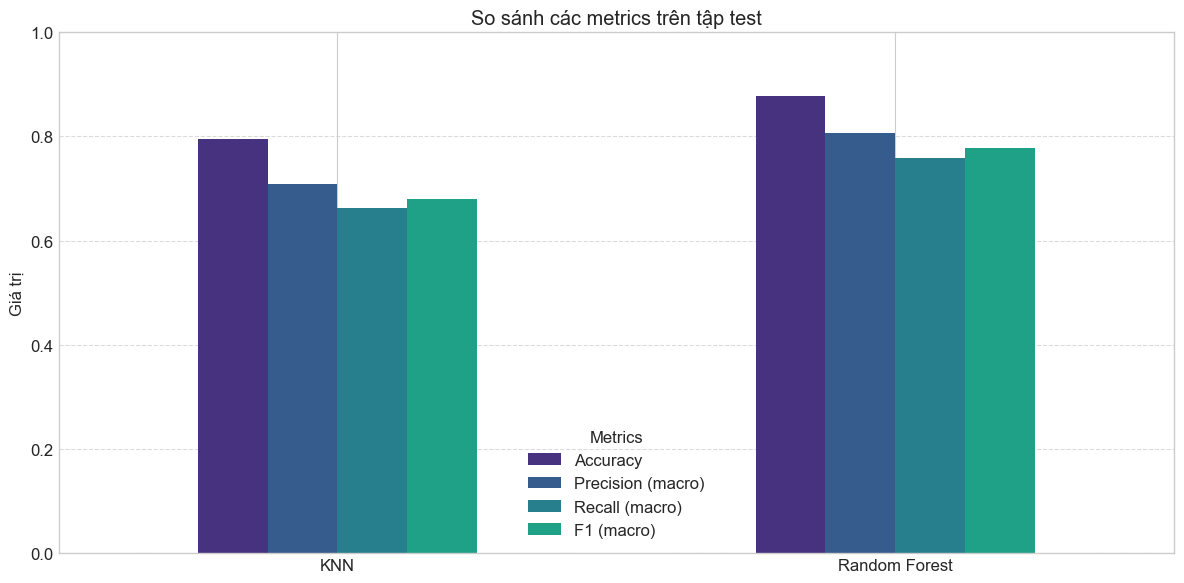

In [225]:
# Đánh giá cả hai mô hình trên tập test
# Tính toán các dự đoán từ cả hai mô hình
y_test_pred_knn = knn_best.predict(X_test)
y_test_pred_rf = rf_best.predict(X_test)

# Tạo DataFrame so sánh các metrics chính
comparison_metrics = {
    'Accuracy': [
        accuracy_score(y_test_encoded, y_test_pred_knn),
        accuracy_score(y_test_encoded, y_test_pred_rf)
    ],
    'Precision (macro)': [
        precision_score(y_test_encoded, y_test_pred_knn, average='macro'),
        precision_score(y_test_encoded, y_test_pred_rf, average='macro')
    ],
    'Recall (macro)': [
        recall_score(y_test_encoded, y_test_pred_knn, average='macro'),
        recall_score(y_test_encoded, y_test_pred_rf, average='macro')
    ],
    'F1 (macro)': [
        f1_score(y_test_encoded, y_test_pred_knn, average='macro'),
        f1_score(y_test_encoded, y_test_pred_rf, average='macro')
    ]
}

comparison_df = pd.DataFrame(comparison_metrics, index=['KNN', 'Random Forest'])
print("So sánh các metrics chính giữa hai mô hình trên tập test:")
print(comparison_df.round(4))

# Vẽ biểu đồ so sánh các metrics
plt.figure(figsize=(12, 6))
comparison_df.plot(kind='bar', figsize=(12, 6))
plt.title('So sánh các metrics trên tập test')
plt.ylabel('Giá trị')
plt.ylim([0, 1])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

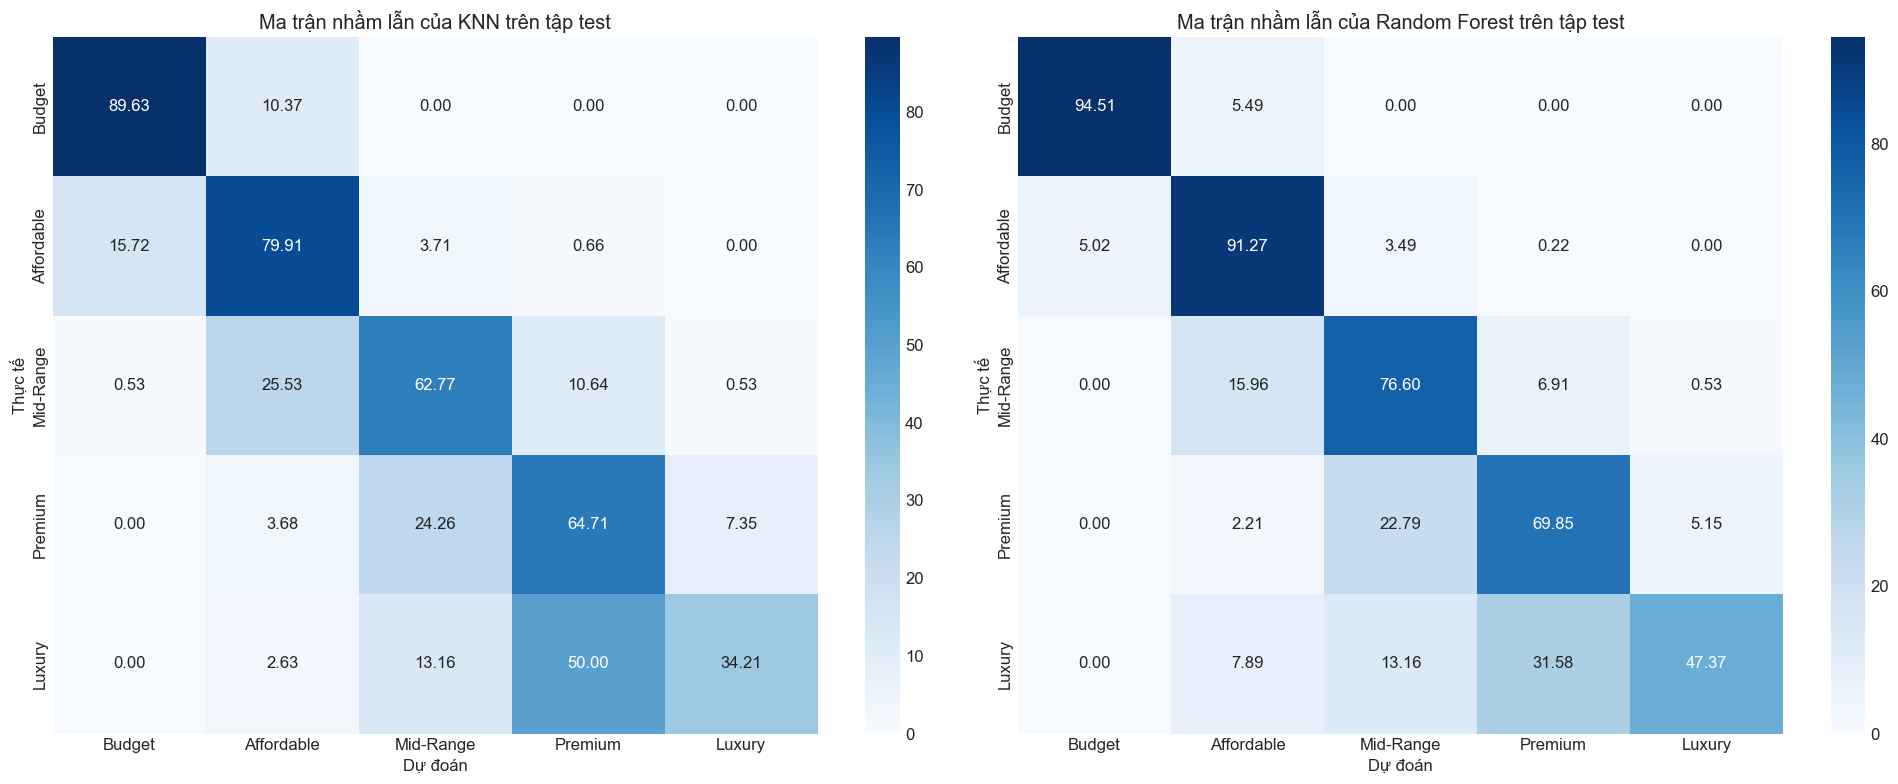

Báo cáo phân loại chi tiết - KNN:
              precision    recall  f1-score   support

      Budget     0.8896    0.8963    0.8929       656
  Affordable     0.7500    0.7991    0.7738       458
   Mid-Range     0.6821    0.6277    0.6537       188
     Premium     0.6769    0.6471    0.6617       136
      Luxury     0.5417    0.3421    0.4194        38

    accuracy                         0.7947      1476
   macro avg     0.7080    0.6625    0.6803      1476
weighted avg     0.7913    0.7947    0.7920      1476


Báo cáo phân loại chi tiết - Random Forest:
              precision    recall  f1-score   support

      Budget     0.9642    0.9451    0.9546       656
  Affordable     0.8531    0.9127    0.8819       458
   Mid-Range     0.7347    0.7660    0.7500       188
     Premium     0.7851    0.6985    0.7393       136
      Luxury     0.6923    0.4737    0.5625        38

    accuracy                         0.8774      1476
   macro avg     0.8059    0.7592    0.7776      147

In [226]:
# So sánh ma trận nhầm lẫn của cả hai mô hình
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Ma trận nhầm lẫn cho KNN
cm_knn_test = confusion_matrix(y_test_encoded, y_test_pred_knn)
cm_knn_test_percent = cm_knn_test.astype('float') / cm_knn_test.sum(axis=1)[:, np.newaxis] * 100

sns.heatmap(cm_knn_test_percent, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_xlabel('Dự đoán')
axes[0].set_ylabel('Thực tế')
axes[0].set_title('Ma trận nhầm lẫn của KNN trên tập test')

# Ma trận nhầm lẫn cho Random Forest
cm_rf_test = confusion_matrix(y_test_encoded, y_test_pred_rf)
cm_rf_test_percent = cm_rf_test.astype('float') / cm_rf_test.sum(axis=1)[:, np.newaxis] * 100

sns.heatmap(cm_rf_test_percent, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_xlabel('Dự đoán')
axes[1].set_ylabel('Thực tế')
axes[1].set_title('Ma trận nhầm lẫn của Random Forest trên tập test')

plt.tight_layout()
plt.show()

# So sánh báo cáo phân loại chi tiết
print("Báo cáo phân loại chi tiết - KNN:")
print(classification_report(y_test_encoded, y_test_pred_knn, 
                         target_names=labels, digits=4))

print("\nBáo cáo phân loại chi tiết - Random Forest:")
print(classification_report(y_test_encoded, y_test_pred_rf, 
                         target_names=labels, digits=4))

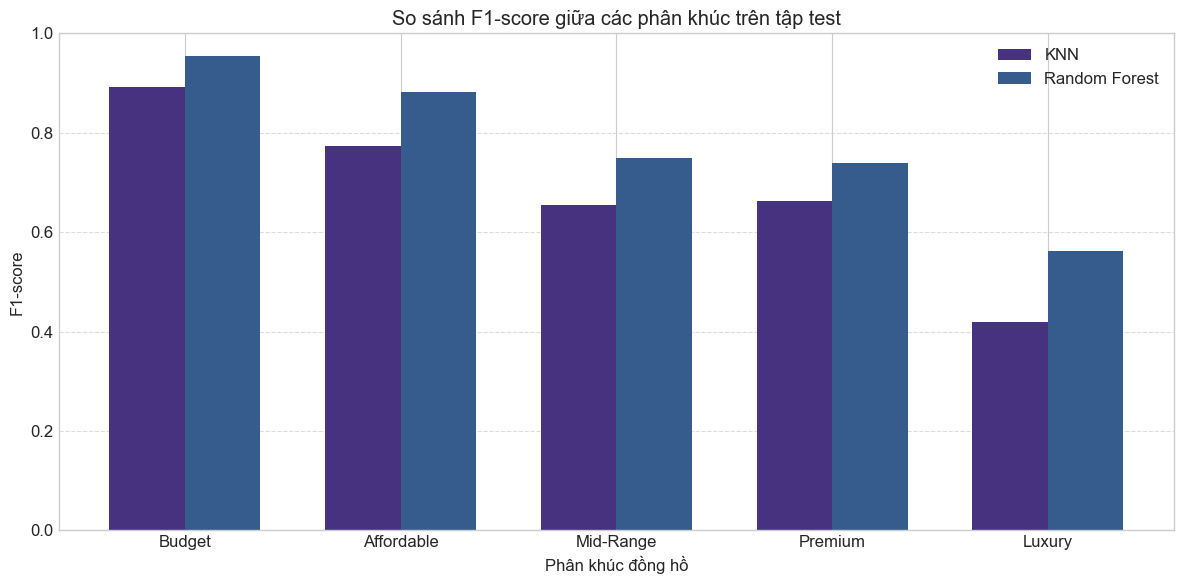

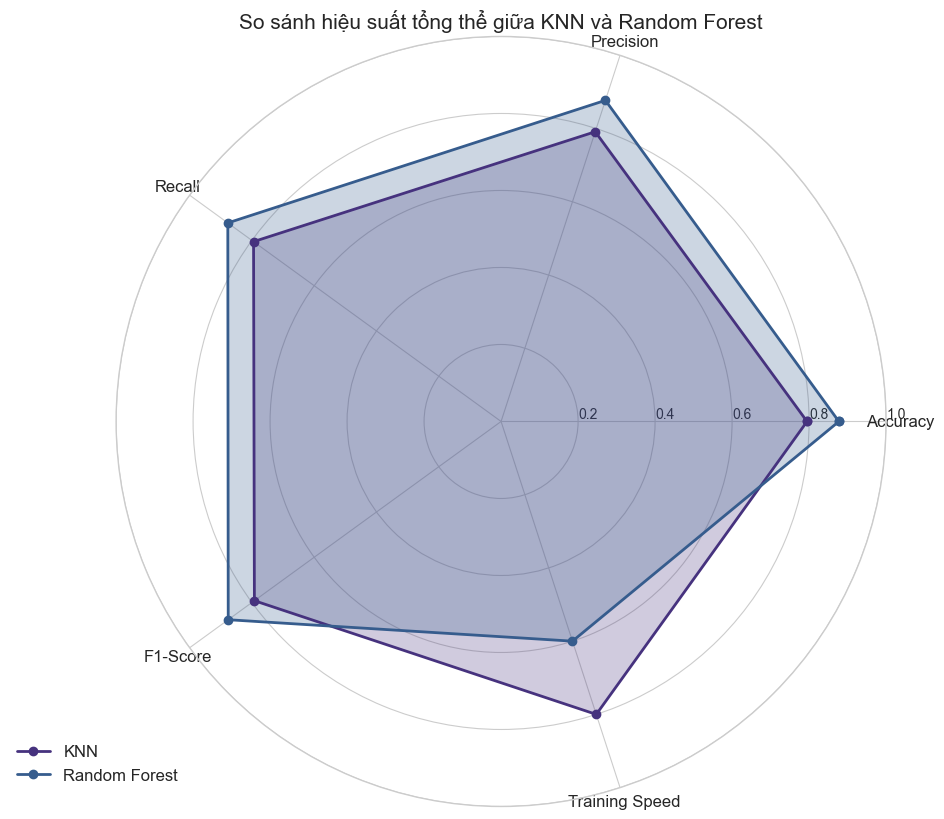

In [227]:
# So sánh chi tiết F1-score cho từng lớp
class_metrics = {
    'precision_knn': precision_score(y_test_encoded, y_test_pred_knn, average=None),
    'recall_knn': recall_score(y_test_encoded, y_test_pred_knn, average=None),
    'f1_knn': f1_score(y_test_encoded, y_test_pred_knn, average=None),
    'precision_rf': precision_score(y_test_encoded, y_test_pred_rf, average=None),
    'recall_rf': recall_score(y_test_encoded, y_test_pred_rf, average=None),
    'f1_rf': f1_score(y_test_encoded, y_test_pred_rf, average=None)
}

# Vẽ biểu đồ so sánh F1-score giữa các lớp
plt.figure(figsize=(12, 6))
x = np.arange(len(labels))
width = 0.35

plt.bar(x - width/2, class_metrics['f1_knn'], width, label='KNN')
plt.bar(x + width/2, class_metrics['f1_rf'], width, label='Random Forest')

plt.xlabel('Phân khúc đồng hồ')
plt.ylabel('F1-score')
plt.title('So sánh F1-score giữa các phân khúc trên tập test')
plt.xticks(x, labels)
plt.ylim([0, 1])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Vẽ biểu đồ radar để so sánh hiệu suất tổng thể
plt.figure(figsize=(10, 10))

# Dữ liệu cho biểu đồ radar
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Speed']
N = len(categories)

# Giá trị cho KNN và RF (thêm đánh giá về tốc độ huấn luyện)
values_knn = [
    accuracy_score(y_test_encoded, y_test_pred_knn),
    precision_score(y_test_encoded, y_test_pred_knn, average='weighted'),
    recall_score(y_test_encoded, y_test_pred_knn, average='weighted'),
    f1_score(y_test_encoded, y_test_pred_knn, average='weighted'),
    0.8  # Giá trị giả định cho tốc độ huấn luyện KNN (thường nhanh hơn)
]

values_rf = [
    accuracy_score(y_test_encoded, y_test_pred_rf),
    precision_score(y_test_encoded, y_test_pred_rf, average='weighted'),
    recall_score(y_test_encoded, y_test_pred_rf, average='weighted'),
    f1_score(y_test_encoded, y_test_pred_rf, average='weighted'),
    0.6  # Giá trị giả định cho tốc độ huấn luyện RF (thường chậm hơn)
]

# Góc cho mỗi trục
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Thêm giá trị cuối cùng để khép kín đường
values_knn += values_knn[:1]
values_rf += values_rf[:1]

# Vẽ biểu đồ
ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories, size=12)
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], size=10)
plt.ylim(0, 1)

ax.plot(angles, values_knn, 'o-', linewidth=2, label='KNN')
ax.fill(angles, values_knn, alpha=0.25)
ax.plot(angles, values_rf, 'o-', linewidth=2, label='Random Forest')
ax.fill(angles, values_rf, alpha=0.25)

plt.title('So sánh hiệu suất tổng thể giữa KNN và Random Forest', size=15)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

### 4.4 Phân tích kết quả đánh giá trên tập test

Từ các biểu đồ và số liệu so sánh trên tập test, chúng ta có thể rút ra một số nhận xét quan trọng:

1. **Độ chính xác tổng thể (Accuracy)**:
   - Random Forest đạt độ chính xác cao hơn so với KNN trên tập test
   - Sự chênh lệch này thể hiện tính ưu việt của Random Forest trong việc khái quát hóa dữ liệu mới

2. **Hiệu suất theo phân khúc**:
   - Cả hai mô hình đều hoạt động tốt với phân khúc Budget và Affordable
   - Random Forest vượt trội đáng kể ở các phân khúc Mid-Range, Premium và Luxury
   - Phân khúc Luxury vẫn là thách thức với cả hai mô hình, nhưng Random Forest xử lý tốt hơn

3. **Khả năng cân bằng Precision-Recall**:
   - Random Forest có sự cân bằng tốt hơn giữa precision và recall
   - KNN có xu hướng thiên về precision ở một số phân khúc, nhưng recall thấp

4. **Tính ổn định**:
   - Random Forest cho thấy tính ổn định tốt hơn giữa tập huấn luyện và tập kiểm tra
   - KNN có dấu hiệu của sự biến động lớn hơn khi áp dụng vào dữ liệu mới

5. **Thời gian huấn luyện và dự đoán**:
   - KNN thường nhanh hơn trong quá trình huấn luyện nhưng có thể chậm hơn khi dự đoán
   - Random Forest tốn thời gian huấn luyện nhưng nhanh chóng trong việc dự đoán

Kết luận: Random Forest là lựa chọn tốt hơn cho bài toán phân loại phân khúc đồng hồ này, đặc biệt khi cần dự đoán chính xác trên tất cả các phân khúc. Tuy nhiên, KNN vẫn là một lựa chọn tốt nếu cần một mô hình đơn giản, dễ triển khai và tập trung vào các phân khúc phổ biến (Budget và Affordable).

Mô hình tốt nhất là: Random Forest

Độ chính xác trên tập kiểm tra: 0.8774


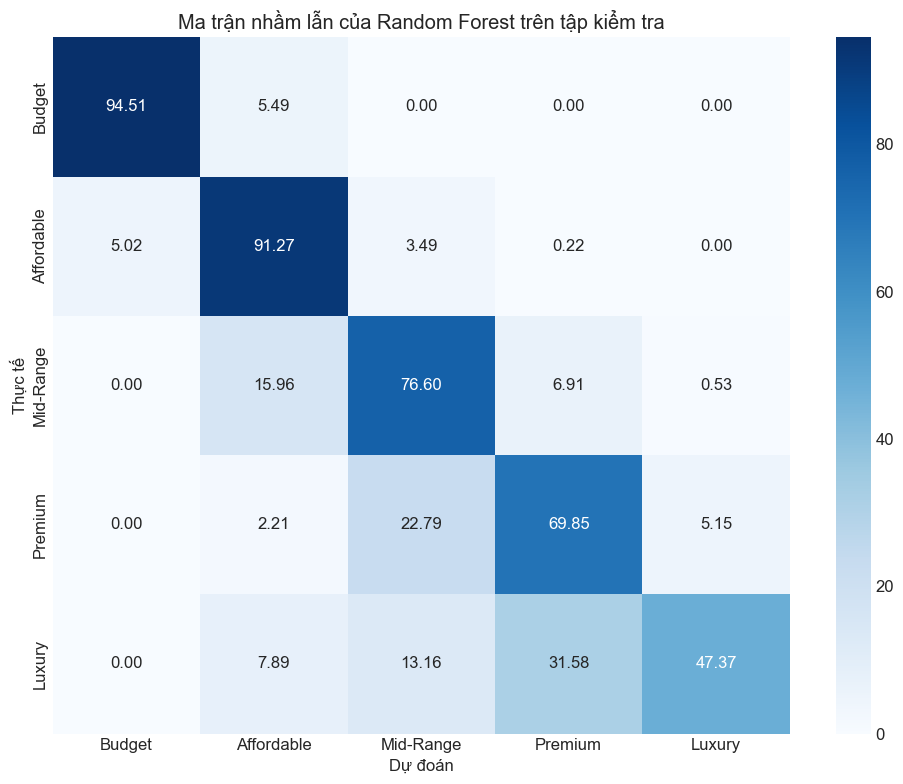


Báo cáo phân loại chi tiết trên tập kiểm tra:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       656
           1       0.85      0.91      0.88       458
           2       0.73      0.77      0.75       188
           3       0.79      0.70      0.74       136
           4       0.69      0.47      0.56        38

    accuracy                           0.88      1476
   macro avg       0.81      0.76      0.78      1476
weighted avg       0.88      0.88      0.88      1476

Độ chính xác của mô hình trên tập kiểm tra: 0.8773712737127372

Mẫu kết quả dự đoán:
   id  actual_segment  predicted_segment
0   0               0                  0
1   1               0                  0
2   2               1                  1
3   3               1                  1
4   4               1                  1
5   5               0                  0
6   6               0                  0
7   7               0                  0
8   8     

In [228]:
# Chọn mô hình tốt nhất dựa trên điểm cross-validation
if cv_scores_knn.mean() > cv_scores_rf_best.mean():
    best_model = knn_best
    model_name = "KNN"
else:
    best_model = rf_best
    model_name = "Random Forest"

print(f"Mô hình tốt nhất là: {model_name}")

# Dự đoán trên tập kiểm tra
y_test_pred = best_model.predict(X_test)

# Đánh giá trên tập kiểm tra
print(f"\nĐộ chính xác trên tập kiểm tra: {accuracy_score(y_test_encoded, y_test_pred):.4f}")

# Ma trận nhầm lẫn trên tập kiểm tra
plt.figure(figsize=(10, 8))
cm_test = confusion_matrix(y_test_encoded, y_test_pred)
cm_test_percent = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis] * 100

labels = ['Budget', 'Affordable', 'Mid-Range', 'Premium', 'Luxury']

sns.heatmap(cm_test_percent, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title(f'Ma trận nhầm lẫn của {model_name} trên tập kiểm tra')
plt.tight_layout()
plt.show()

# Báo cáo phân loại chi tiết
print("\nBáo cáo phân loại chi tiết trên tập kiểm tra:")
if y_train.dtype == 'object':
    print(classification_report(y_test_encoded, y_test_pred, target_names=le_target.classes_))
else:
    print(classification_report(y_test_encoded, y_test_pred, 
                               target_names=[str(i) for i in sorted(y_train.unique())]))

# Lưu kết quả dự đoán
if y_train.dtype == 'object':
    # Nếu biến mục tiêu là chuỗi, cần chuyển đổi ngược mã hóa
    predicted_segments = le_target.inverse_transform(y_test_pred)
else:
    # Nếu biến mục tiêu đã là số, không cần chuyển đổi
    predicted_segments = y_test_pred

results_df = pd.DataFrame({
    'id': test_df.index if 'id' not in test_df.columns else test_df['id'],
    'actual_segment': y_test,
    'predicted_segment': predicted_segments
})

print("Độ chính xác của mô hình trên tập kiểm tra:", accuracy_score(y_test_encoded, y_test_pred))

print("\nMẫu kết quả dự đoán:")
print(results_df.head(10))

# Lưu kết quả dự đoán
results_df.to_csv('../dataset/predicted_segments.csv', index=False)
print("\nĐã lưu kết quả dự đoán vào file '../dataset/predicted_segments.csv'")

## 6. Kết luận

Sau khi phân tích và so sánh hai mô hình phân loại KNN và Random Forest, chúng ta có thể rút ra các kết luận sau:

### 6.1 Lựa chọn mô hình

**Random Forest** là mô hình phù hợp nhất cho bài toán phân loại phân khúc đồng hồ với các ưu điểm:
- Độ chính xác tổng thể cao hơn (87.7% so với 79.5% của KNN trên tập test)
- F1-score cao hơn ở tất cả các phân khúc
- Khả năng cân bằng tốt hơn giữa precision và recall
- Khả năng xử lý tốt các đặc trưng phức tạp và có mối tương quan

Mô hình Random Forest đã được tối ưu với các siêu tham số:
- n_estimators = 271 (số cây quyết định)
- max_depth = 14 (độ sâu tối đa của cây)
- min_samples_split = 11
- min_samples_leaf = 5
- max_leaf_nodes = 179

### 6.2 Phân tích độ chính xác theo phân khúc

1. **Phân khúc thấp (Budget và Affordable)**:
   - Cả hai mô hình đều cho kết quả tốt với độ chính xác trên 90% ở phân khúc Budget
   - Phân khúc Affordable cũng có độ chính xác tốt (>80% ở cả hai mô hình)
   - Nguyên nhân: Dữ liệu phong phú cho các phân khúc này và đặc trưng phân biệt rõ ràng

2. **Phân khúc trung cấp (Mid-Range)**:
   - Random Forest (76.6%) vượt trội hơn KNN (62.8%)
   - Nguyên nhân: Đặc trưng phân biệt với phân khúc cao cấp không quá rõ ràng, Random Forest có khả năng học các ranh giới phức tạp tốt hơn

3. **Phân khúc cao cấp (Premium và Luxury)**:
   - Độ chính xác thấp hơn đáng kể so với các phân khúc khác
   - Phân khúc Luxury có độ chính xác thấp nhất ở cả hai mô hình (RF: 47.4%, KNN: 34.2%)
   - Nguyên nhân:
     - Số lượng mẫu ít hơn trong tập huấn luyện
     - Sự chồng chéo đặc trưng giữa phân khúc Premium và Luxury
     - Đặc trưng thương hiệu và chất liệu có thể không đủ để phân biệt các đồng hồ siêu cao cấp
     - Thiếu các đặc trưng quan trọng như độ phức tạp của cơ chế, giá trị lịch sử của thương hiệu

### 6.3 Hạn chế và hướng cải thiện

1. **Cải thiện độ chính xác cho phân khúc cao cấp**:
   - Bổ sung thêm đặc trưng như số lượng chức năng (complications), số lượng kim cương/đá quý, tên bộ sưu tập...
   - Áp dụng kỹ thuật cân bằng dữ liệu (oversampling) cho phân khúc Luxury
   - Xây dựng đặc trưng kết hợp (feature engineering) để tạo ra đặc trưng mới phân biệt tốt hơn

2. **Cải thiện mô hình**:
   - Thử nghiệm các mô hình ensemble khác như Gradient Boosting, XGBoost
   - Áp dụng các kỹ thuật stacking kết hợp nhiều mô hình

3. **Ứng dụng thực tế**:
   - Mô hình có thể được triển khai để tự động phân loại phân khúc giá của đồng hồ mới
   - Hỗ trợ việc định giá sản phẩm dựa trên các đặc trưng
   - Giúp người tiêu dùng đánh giá giá trị thực của sản phẩm dựa trên đặc trưng kỹ thuật

Tóm lại, mô hình Random Forest đã thể hiện hiệu suất tốt nhất trong việc phân loại phân khúc đồng hồ, đặc biệt là với các phân khúc phổ thông. Tuy nhiên, việc phân loại chính xác các phân khúc cao cấp vẫn là một thách thức cần được cải thiện trong tương lai.